# Modelos para a classificação de diabetes


É importante ressaltar que os dados do Vigitel não devem ser analisados no Excel, do pacote Office (ou programa semelhante), pois a amostra do Vigitel leva em consideração fatores de ponderação para a análise de dados.

É necessário o uso de programas como o Epi Info ou R, ou, ainda, Stata, SPSS, SAS, entre outros, que possuem módulos de análise específicos para a utilização de fatores de ponderação

Link da base: https://svs.aids.gov.br/download/Vigitel/

trabalho relacionado que usou vigitel: https://www.scielo.br/j/ress/a/6hn69ts9c5mkPjHcGBMBbGJ/?lang=pt

referências:
artigo que usa métodos de ml para prever diabetico ou não
https://www.mdpi.com/1424-8220/22/16/6155

# Tratamento de dados

#### Bibliotecas e setar diretório

rodar e reiniciar..

In [75]:
# try:
#   import dython
#   from dython.nominal import associations
# except:
#   ! pip install dython
#   import dython
#   from dython.nominal import associations

In [76]:
import xgboost as xgb
import multiprocessing

In [77]:
# !pip uninstall shap
# !pip install shap

In [78]:
# !kill -9 -1

In [79]:

# import pkg_resources
# # pkg_resources.require("numpy== 1.22.4")
# import numpy as np
# !pip show numpy

# import dython
# from dython.nominal import associations

In [80]:
import pandas as pd
pd.set_option('display.max_columns', 250)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

In [81]:

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import de dados

In [83]:
# read file from google drive at folder databetes
# file_path = 'drive/My Drive/databetes/Vigitel-2021-peso-rake.xls'
# file_path = 'drive/My Drive/databetes/Vigitel-2020-peso-rake.xls'
file_path = "drive/My Drive/databetes/data/processed/PNS_2019/pns_model_test.csv"
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df_test = pd.read_csv(file_path)

In [84]:
df_test

,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,bebida_alcoolica,Idade,Dias Álcool,Unidade
0,19.382145,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,25 a 34 anos,NaN,Pernambuco
1,20.715694,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,35 a 44 anos,NaN,Espírito Santo
2,34.577632,0,sim,não,curso ginasial ou ginásio,0,65 anos e mais,NaN,Rio de Janeiro
3,29.938272,0,não,não,3º grau ou curso superior,2,35 a 44 anos,1.0,Santa Catarina
4,25.636917,0,sim,sim,nunca estudou,0,55 a 64 anos,NaN,Acre
...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,2,45 a 54 anos,2.0,Mato Grosso
57333,29.069767,0,não,sim,2º grau ou colégio ou técnico ou normal ou cie...,2,18 a 24 anos,5.0,Rio de Janeiro
57334,19.531250,0,não,não,nunca estudou,0,45 a 54 anos,NaN,Rondônia
57335,31.833910,0,não,sim,3º grau ou curso superior,2,35 a 44 anos,2.0,Ceará


In [85]:
df_test = df_test[['IMC', 'diabetes','pressao_alta','exercicio_fisico','grau_escolaridade', 'bebida_alcoolica','Idade']]

In [86]:
df_test

,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,bebida_alcoolica,Idade
0,19.382145,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,25 a 34 anos
1,20.715694,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,35 a 44 anos
2,34.577632,0,sim,não,curso ginasial ou ginásio,0,65 anos e mais
3,29.938272,0,não,não,3º grau ou curso superior,2,35 a 44 anos
4,25.636917,0,sim,sim,nunca estudou,0,55 a 64 anos
...,...,...,...,...,...,...,...
57332,27.343750,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,2,45 a 54 anos
57333,29.069767,0,não,sim,2º grau ou colégio ou técnico ou normal ou cie...,2,18 a 24 anos
57334,19.531250,0,não,não,nunca estudou,0,45 a 54 anos
57335,31.833910,0,não,sim,3º grau ou curso superior,2,35 a 44 anos


In [87]:
def preprocess_subset(df):
  rename_cols_dict = {
                            'bebida_alcoolica':'cat_alcool',
                            'Idade':'faixa_etaria'
                                }

  df = df.rename(columns=rename_cols_dict)

  def one_hot_encode(df,cols):
    # checar se são todos uniques
    # for col in cols:
      # display(df[col].unique())
    df = pd.get_dummies(data=df, columns=cols)
    display(df)
    return df

  # df_model = one_hot_encode(df_model,cols=['pressao_alta','exercicio_fisico','grau_escolaridade','bebida_alcoolica','faixa_etaria'])
  #convertendo a categoria de alcool em categorica
  df_model = one_hot_encode(df,cols=['cat_alcool'])
  for col in ['cat_alcool_3','cat_alcool_4','cat_alcool_5','cat_alcool_6','cat_alcool_7']:
    print(col)
    df_model[col] = 0
  df_model = one_hot_encode(df_model,cols=['pressao_alta','exercicio_fisico','grau_escolaridade','faixa_etaria'])
  # df_model['diabetes'] = df_model['diabetes'].map({'não':0,
  #                                                             'sim':1
  #                                                             })
  return df_model

df_test = preprocess_subset(df_test)
df_test

,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,faixa_etaria,cat_alcool_0,cat_alcool_1,cat_alcool_2
0,19.382145,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,25 a 34 anos,1,0,0
1,20.715694,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,35 a 44 anos,1,0,0
2,34.577632,0,sim,não,curso ginasial ou ginásio,65 anos e mais,1,0,0
3,29.938272,0,não,não,3º grau ou curso superior,35 a 44 anos,0,0,1
4,25.636917,0,sim,sim,nunca estudou,55 a 64 anos,1,0,0
...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,45 a 54 anos,0,0,1
57333,29.069767,0,não,sim,2º grau ou colégio ou técnico ou normal ou cie...,18 a 24 anos,0,0,1
57334,19.531250,0,não,não,nunca estudou,45 a 54 anos,1,0,0
57335,31.833910,0,não,sim,3º grau ou curso superior,35 a 44 anos,0,0,1


cat_alcool_3
cat_alcool_4
cat_alcool_5
cat_alcool_6
cat_alcool_7


,IMC,diabetes,cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_3,cat_alcool_4,cat_alcool_5,cat_alcool_6,cat_alcool_7,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24 anos,faixa_etaria_25 a 34 anos,faixa_etaria_35 a 44 anos,faixa_etaria_45 a 54 anos,faixa_etaria_55 a 64 anos,faixa_etaria_65 anos e mais
0,19.382145,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,20.715694,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,34.577632,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,29.938272,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,25.636917,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
57333,29.069767,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
57334,19.531250,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
57335,31.833910,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


,IMC,diabetes,cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_3,cat_alcool_4,cat_alcool_5,cat_alcool_6,cat_alcool_7,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24 anos,faixa_etaria_25 a 34 anos,faixa_etaria_35 a 44 anos,faixa_etaria_45 a 54 anos,faixa_etaria_55 a 64 anos,faixa_etaria_65 anos e mais
0,19.382145,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,20.715694,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,34.577632,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,29.938272,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,25.636917,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
57333,29.069767,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
57334,19.531250,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
57335,31.833910,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [88]:
a

NameError: ignored

In [90]:

df_test

,IMC,diabetes,cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_3,cat_alcool_4,cat_alcool_5,cat_alcool_6,cat_alcool_7,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24 anos,faixa_etaria_25 a 34 anos,faixa_etaria_35 a 44 anos,faixa_etaria_45 a 54 anos,faixa_etaria_55 a 64 anos,faixa_etaria_65 anos e mais
0,19.382145,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,20.715694,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,34.577632,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,29.938272,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,25.636917,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
57333,29.069767,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
57334,19.531250,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
57335,31.833910,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [89]:
import joblib
loaded_model = joblib.load("drive/My Drive/databetes/assets/gustavo/smote_model.pkl")
loaded_model

RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
                       n_estimators=160, random_state=21)

In [95]:
X_test =  df_test.drop('diabetes', axis=1)
X_test =  df_test.drop(['cat_alcool_3','cat_alcool_6'], axis=1)

y_test = df_test['diabetes']

In [99]:
X_test=  X_test.drop('diabetes', axis=1)
X_test

,IMC,cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_4,cat_alcool_5,cat_alcool_7,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24 anos,faixa_etaria_25 a 34 anos,faixa_etaria_35 a 44 anos,faixa_etaria_45 a 54 anos,faixa_etaria_55 a 64 anos,faixa_etaria_65 anos e mais
0,19.382145,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,20.715694,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,34.577632,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,29.938272,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,25.636917,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
57333,29.069767,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
57334,19.531250,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
57335,31.833910,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [106]:
ordem_colunas = [
    'IMC',
    'pressao_alta_não',
    'pressao_alta_sim',
    'exercicio_fisico_não',
    'exercicio_fisico_sim',
    'grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau',
    'grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau',
    'grau_escolaridade_3º grau ou curso superior',
    'grau_escolaridade_admissão',
    'grau_escolaridade_curso ginasial ou ginásio',
    'grau_escolaridade_curso primário',
    'grau_escolaridade_nunca estudou',
    'grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)',
    'cat_alcool_0',
    'cat_alcool_1',
    'cat_alcool_2',
    'cat_alcool_4',
    'cat_alcool_5',
    'cat_alcool_7',
    'faixa_etaria_18 a 24 anos',
    'faixa_etaria_25 a 34 anos',
    'faixa_etaria_35 a 44 anos',
    'faixa_etaria_45 a 54 anos',
    'faixa_etaria_55 a 64 anos',
    'faixa_etaria_65 anos e mais'
]


X_test =X_test[ordem_colunas]
X_test

,IMC,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_4,cat_alcool_5,cat_alcool_7,faixa_etaria_18 a 24 anos,faixa_etaria_25 a 34 anos,faixa_etaria_35 a 44 anos,faixa_etaria_45 a 54 anos,faixa_etaria_55 a 64 anos,faixa_etaria_65 anos e mais
0,19.382145,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,20.715694,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,34.577632,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,29.938272,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,25.636917,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57332,27.343750,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
57333,29.069767,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
57334,19.531250,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
57335,31.833910,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [107]:
y_pred = loaded_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [108]:
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [104]:
from sklearn.metrics import roc_curve,roc_auc_score,auc
def print_classification_report(y_val, y_val_pred,y_val_pred_proba=None,auc_metrics=True):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    # Gerando o relatório com diversas métricas
    report = classification_report(y_val, y_val_pred)

    # Exibindo o relatório
    print(report)


    # Plotando a matriz de confusão
    matriz_confusão = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()
    total1=sum(sum(matriz_confusão))
    #####from confusion matrix calculate accuracy
    # accuracy1=(matriz_confusão[0,0]+matriz_confusão[1,1])/total1
    # print ('Accuracy : ', accuracy1)
    sensitivity1 = matriz_confusão[0,0]/(matriz_confusão[0,0]+matriz_confusão[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = matriz_confusão[1,1]/(matriz_confusão[1,0]+matriz_confusão[1,1])
    print('Specificity : ', specificity1)
    if auc_metrics == True:
      # Calculate False Positive Rate (FPR) and True Positive Rate (TPR)
      fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
      # Calculate AUC score
      auc = roc_auc_score(y_val, y_val_pred_proba)
      print(f'AUC = {auc} ')
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
      plt.plot([0, 1], [0, 1], 'r--')
      plt.xlim([0, 1])
      plt.ylim([0, 1])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      plt.close()


Acurácia na validação: 68.26%
Acurácia balanceada na validação: 72.50%
              precision    recall  f1-score   support

           0       0.97      0.67      0.80     52376
           1       0.18      0.78      0.30      4961

    accuracy                           0.68     57337
   macro avg       0.58      0.73      0.55     57337
weighted avg       0.90      0.68      0.75     57337



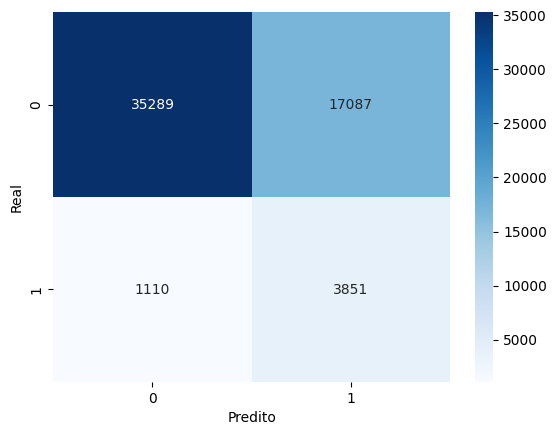

Sensitivity :  0.6737627921185275
Specificity :  0.7762547873412619
AUC = 0.7870322723752063 


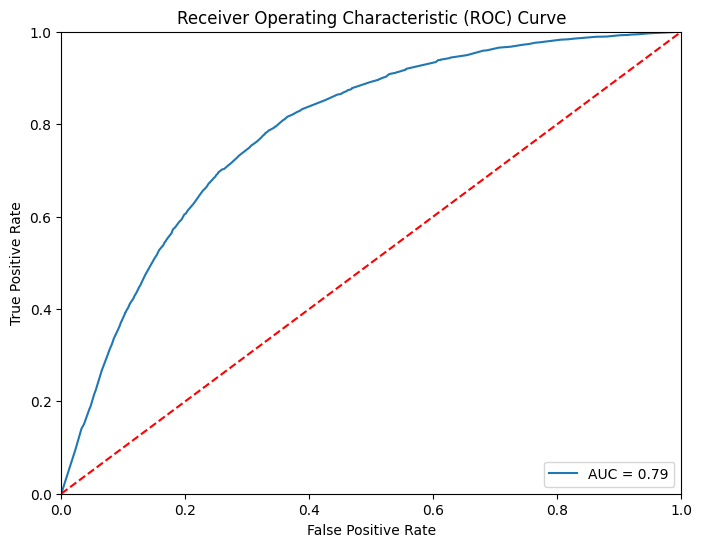

In [109]:
print_classification_report(y_test, y_pred,y_pred_proba)

## testando várias cidades

In [134]:
df_test_cache

,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,bebida_alcoolica,Idade,Dias Álcool,Unidade
0,19.382145,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,25 a 34 anos,NaN,Pernambuco
1,20.715694,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,35 a 44 anos,NaN,Espírito Santo
2,34.577632,0,sim,não,curso ginasial ou ginásio,0,65 anos e mais,NaN,Rio de Janeiro
3,29.938272,0,não,não,3º grau ou curso superior,2,35 a 44 anos,1.0,Santa Catarina
4,25.636917,0,sim,sim,nunca estudou,0,55 a 64 anos,NaN,Acre
...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,2,45 a 54 anos,2.0,Mato Grosso
57333,29.069767,0,não,sim,2º grau ou colégio ou técnico ou normal ou cie...,2,18 a 24 anos,5.0,Rio de Janeiro
57334,19.531250,0,não,não,nunca estudou,0,45 a 54 anos,NaN,Rondônia
57335,31.833910,0,não,sim,3º grau ou curso superior,2,35 a 44 anos,2.0,Ceará


In [136]:

df_test

,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,bebida_alcoolica,Idade,Dias Álcool,Unidade
0,19.382145,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,25 a 34 anos,NaN,Pernambuco
1,20.715694,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,35 a 44 anos,NaN,Espírito Santo
2,34.577632,0,sim,não,curso ginasial ou ginásio,0,65 anos e mais,NaN,Rio de Janeiro
3,29.938272,0,não,não,3º grau ou curso superior,2,35 a 44 anos,1.0,Santa Catarina
4,25.636917,0,sim,sim,nunca estudou,0,55 a 64 anos,NaN,Acre
...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,2,45 a 54 anos,2.0,Mato Grosso
57333,29.069767,0,não,sim,2º grau ou colégio ou técnico ou normal ou cie...,2,18 a 24 anos,5.0,Rio de Janeiro
57334,19.531250,0,não,não,nunca estudou,0,45 a 54 anos,NaN,Rondônia
57335,31.833910,0,não,sim,3º grau ou curso superior,2,35 a 44 anos,2.0,Ceará


In [150]:
def print_classification_report_with_df(y_val, y_val_pred,y_val_pred_proba=None,auc_metrics=True,state=None):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    # Gerando o relatório com diversas métricas
    report = classification_report(y_val, y_val_pred)

    # Exibindo o relatório
    print(report)


    # Plotando a matriz de confusão
    matriz_confusão = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()
    total1=sum(sum(matriz_confusão))
    #####from confusion matrix calculate accuracy
    # accuracy1=(matriz_confusão[0,0]+matriz_confusão[1,1])/total1
    # print ('Accuracy : ', accuracy1)
    sensitivity1 = matriz_confusão[0,0]/(matriz_confusão[0,0]+matriz_confusão[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = matriz_confusão[1,1]/(matriz_confusão[1,0]+matriz_confusão[1,1])
    print('Specificity : ', specificity1)
    if auc_metrics == True:
      # Calculate False Positive Rate (FPR) and True Positive Rate (TPR)
      fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
      # Calculate AUC score
      auc = roc_auc_score(y_val, y_val_pred_proba)
      print(f'AUC = {auc} ')
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
      plt.plot([0, 1], [0, 1], 'r--')
      plt.xlim([0, 1])
      plt.ylim([0, 1])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      plt.close()


    metrics = [[state,auc, sensitivity1, specificity1,val_balanced_accuracy,val_accuracy]]
    df_metrics = pd.DataFrame(metrics, columns=['Estado','AUC', 'sensitivity', 'specificity', 'Acurácia balanceada','Acurácia'])

    return df_metrics

In [158]:
# file_path = "drive/My Drive/databetes/data/processed/PNS_2019/pns_model_test.csv"
# # file_path = '../data/Vigitel-2019-peso-rake.xls'
# # df = pd.read_excel(file_path, sheet_name='Sheet1')
# df_test_cache = pd.read_csv(file_path)

# # df_test = df_test_cache
# df_test = df_test_cache.copy()
# df_full_metrics = pd.DataFrame()
# for city in df_test['Unidade'].unique():
#   try:
#     df_test = df_test_cache.copy()
#     print(city)
#     df_test = df_test[df_test['Unidade'] == city]
#     df_test = df_test[['IMC', 'diabetes','pressao_alta','exercicio_fisico','grau_escolaridade', 'bebida_alcoolica','Idade']]

#     df_test = preprocess_subset(df_test)

#     X_test =  df_test.drop('diabetes', axis=1)
#     X_test =  df_test.drop(['cat_alcool_3','cat_alcool_6'], axis=1)

#     y_test = df_test['diabetes']
#     X_test=  X_test.drop('diabetes', axis=1)

#     X_test =X_test[ordem_colunas]

#     y_pred = loaded_model.predict(X_test)
#     y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

#     print_classification_report(y_test, y_pred,y_pred_proba)
#     df_met = print_classification_report_with_df(y_test, y_pred,y_pred_proba,state=city)
#     display(df_met)
#     # df_full_metrics = df_full_metrics.concat(df_met)
#     df_full_metrics = pd.concat([df_full_metrics,df_met])
#   except Exception as e:
#     print(f'problema com a cidade {city}: \n {e}')
# df_full_metrics

In [153]:
file_path = "drive/My Drive/databetes/data/processed/PNS_2019/pns_model_test.csv"
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df_test_cache = pd.read_csv(file_path)

# df_test = df_test_cache
df_test = df_test_cache.copy()
df_full_metrics = pd.DataFrame()
for city in df_test['Unidade'].unique():

  df_test = df_test_cache.copy()
  print(city)
  df_test = df_test[df_test['Unidade'] == city]
  df_test = df_test[['IMC', 'diabetes','pressao_alta','exercicio_fisico','grau_escolaridade', 'bebida_alcoolica','Idade']]

  df_test = preprocess_subset(df_test)

  X_test =  df_test.drop('diabetes', axis=1)
  X_test =  df_test.drop(['cat_alcool_3','cat_alcool_6'], axis=1)

  y_test = df_test['diabetes']
  X_test=  X_test.drop('diabetes', axis=1)
  try:
    X_test =X_test[ordem_colunas]
  except KeyError:
    # "['grau_escolaridade_curso primário'] not in index"
    X_test['grau_escolaridade_curso primário'] = 0
    X_test =X_test[ordem_colunas]

  y_pred = loaded_model.predict(X_test)
  y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

  # print_classification_report(y_test, y_pred,y_pred_proba)
  df_met = print_classification_report_with_df(y_test, y_pred,y_pred_proba,state=city)
  display(df_met)
  # df_full_metrics = df_full_metrics.concat(df_met)
  df_full_metrics = pd.concat([df_full_metrics,df_met])

df_full_metrics

Output hidden; open in https://colab.research.google.com to view.

In [157]:
df_full_metrics.sort_values(by=['AUC'],ascending=[False])
# df.sort_values(by=['col1','col2'],ascending=[True,False])

,Estado,AUC,sensitivity,specificity,Acurácia balanceada,Acurácia
0,Mato Grosso,0.824723,0.703368,0.785714,0.744541,0.709581
0,Bahia,0.821474,0.694207,0.848315,0.771261,0.706889
0,Maranhão,0.820457,0.761762,0.736111,0.748937,0.760274
0,Acre,0.814020,0.723032,0.822785,0.772908,0.730144
0,Rio Grande do Norte,0.809859,0.697448,0.788732,0.743090,0.704698
0,Roraima,0.802845,0.763276,0.675325,0.719301,0.757576
0,Distrito Federal,0.802755,0.753846,0.681481,0.717664,0.747853
0,Goiás,0.799994,0.650884,0.824390,0.737637,0.669050
0,Paraná,0.797419,0.647758,0.810277,0.729017,0.662124
0,Alagoas,0.797003,0.689956,0.806897,0.748426,0.701119


In [159]:
df_test_cache

,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,bebida_alcoolica,Idade,Dias Álcool,Unidade
0,19.382145,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,25 a 34 anos,NaN,Pernambuco
1,20.715694,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,0,35 a 44 anos,NaN,Espírito Santo
2,34.577632,0,sim,não,curso ginasial ou ginásio,0,65 anos e mais,NaN,Rio de Janeiro
3,29.938272,0,não,não,3º grau ou curso superior,2,35 a 44 anos,1.0,Santa Catarina
4,25.636917,0,sim,sim,nunca estudou,0,55 a 64 anos,NaN,Acre
...,...,...,...,...,...,...,...,...,...
57332,27.343750,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,2,45 a 54 anos,2.0,Mato Grosso
57333,29.069767,0,não,sim,2º grau ou colégio ou técnico ou normal ou cie...,2,18 a 24 anos,5.0,Rio de Janeiro
57334,19.531250,0,não,não,nunca estudou,0,45 a 54 anos,NaN,Rondônia
57335,31.833910,0,não,sim,3º grau ou curso superior,2,35 a 44 anos,2.0,Ceará


## testando homens e mulheres

In [ ]:
file_path = "drive/My Drive/databetes/data/processed/PNS_2019/pns_model_test.csv"
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df_test_cache = pd.read_csv(file_path)

# df_test = df_test_cache
df_test = df_test_cache.copy()
df_full_metrics = pd.DataFrame()
for city in df_test['Unidade'].unique():
  try:
    df_test = df_test_cache.copy()
    print(city)
    # df_test = df_test[df_test['Unidade'] == city]
    # df_test = df_test[['IMC', 'diabetes','pressao_alta','exercicio_fisico','grau_escolaridade', 'bebida_alcoolica','Idade']]

    # df_test = preprocess_subset(df_test)

    # X_test =  df_test.drop('diabetes', axis=1)
    # X_test =  df_test.drop(['cat_alcool_3','cat_alcool_6'], axis=1)

    # y_test = df_test['diabetes']
    # X_test=  X_test.drop('diabetes', axis=1)

    # X_test =X_test[ordem_colunas]

    # y_pred = loaded_model.predict(X_test)
    # y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

    # print_classification_report(y_test, y_pred,y_pred_proba)
    # df_met = print_classification_report_with_df(y_test, y_pred,y_pred_proba,state=city)
    # display(df_met)
    # # df_full_metrics = df_full_metrics.concat(df_met)
    # df_full_metrics = pd.concat([df_full_metrics,df_met])
  except Exception as e:
    print(f'problema com a cidade {city}: \n {e}')
df_full_metrics

# Estudo de caso

vamos escolher dois estados para analisar,  Mato Grosso e Maranhão,estados com métricas parecidas e diferenças sutis na proporção de diabéticos

Mato Grosso do Sul


,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,faixa_etaria,cat_alcool_0,cat_alcool_1,cat_alcool_2
5,22.136740,0,não,sim,3º grau ou curso superior,25 a 34 anos,0,0,1
23,33.203125,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,35 a 44 anos,0,0,1
28,28.398718,0,não,não,3º grau ou curso superior,25 a 34 anos,1,0,0
38,24.767566,0,sim,não,2º grau ou colégio ou técnico ou normal ou cie...,55 a 64 anos,1,0,0
58,28.049671,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,45 a 54 anos,1,0,0
...,...,...,...,...,...,...,...,...,...
57198,24.221453,0,sim,não,2º grau ou colégio ou técnico ou normal ou cie...,55 a 64 anos,1,0,0
57204,22.720438,0,não,sim,3º grau ou curso superior,35 a 44 anos,0,0,1
57255,34.577632,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,55 a 64 anos,0,0,1
57296,32.029086,0,sim,não,2º grau ou colégio ou técnico ou normal ou cie...,35 a 44 anos,0,0,1


cat_alcool_3
cat_alcool_4
cat_alcool_5
cat_alcool_6
cat_alcool_7


,IMC,diabetes,cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_3,cat_alcool_4,cat_alcool_5,cat_alcool_6,cat_alcool_7,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24 anos,faixa_etaria_25 a 34 anos,faixa_etaria_35 a 44 anos,faixa_etaria_45 a 54 anos,faixa_etaria_55 a 64 anos,faixa_etaria_65 anos e mais
5,22.136740,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
23,33.203125,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
28,28.398718,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
38,24.767566,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
58,28.049671,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57198,24.221453,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
57204,22.720438,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
57255,34.577632,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
57296,32.029086,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


Acurácia na validação: 66.32%
Acurácia balanceada na validação: 70.10%
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      1922
           1       0.18      0.75      0.29       198

    accuracy                           0.66      2120
   macro avg       0.57      0.70      0.54      2120
weighted avg       0.89      0.66      0.73      2120



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


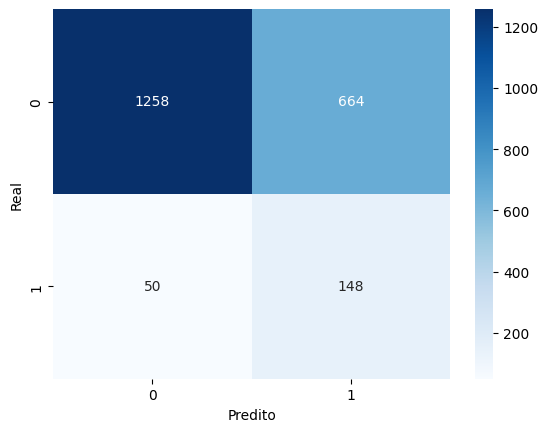

Sensitivity :  0.6545265348595213
Specificity :  0.7474747474747475
AUC = 0.755719263393561 


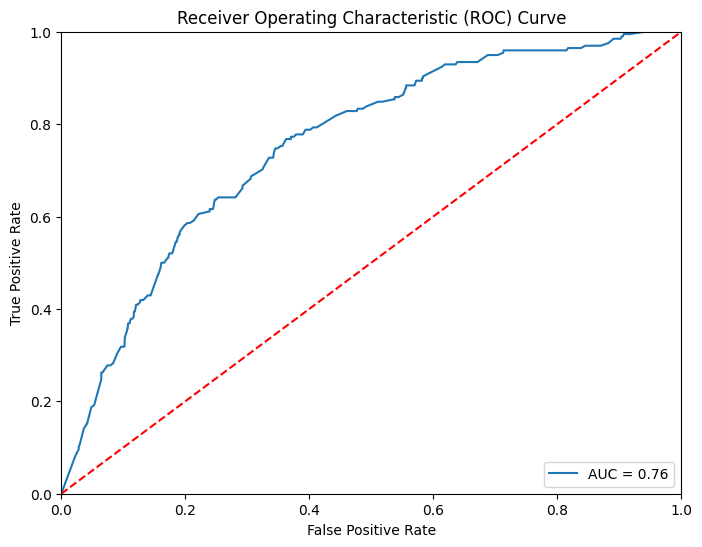

,Estado,AUC,sensitivity,specificity,Acurácia balanceada,Acurácia
0,Mato Grosso do Sul,0.755719,0.654527,0.747475,0.701001,0.663208


Mato Grosso


,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,faixa_etaria,cat_alcool_0,cat_alcool_1,cat_alcool_2
40,35.937500,0,não,não,3º grau ou curso superior,55 a 64 anos,1,0,0
59,26.729927,0,sim,não,nunca estudou,55 a 64 anos,0,0,1
97,37.345679,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,35 a 44 anos,1,0,0
114,23.183673,1,não,não,2º grau ou colégio ou técnico ou normal ou cie...,55 a 64 anos,0,1,0
126,31.588613,0,não,não,3º grau ou curso superior,35 a 44 anos,1,0,0
...,...,...,...,...,...,...,...,...,...
57238,19.979188,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,45 a 54 anos,1,0,0
57273,34.680935,0,sim,sim,3º grau ou curso superior,45 a 54 anos,1,0,0
57274,27.609452,1,sim,sim,2º grau ou colégio ou técnico ou normal ou cie...,65 anos e mais,1,0,0
57329,31.229454,0,não,não,nunca estudou,65 anos e mais,1,0,0


cat_alcool_3
cat_alcool_4
cat_alcool_5
cat_alcool_6
cat_alcool_7


,IMC,diabetes,cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_3,cat_alcool_4,cat_alcool_5,cat_alcool_6,cat_alcool_7,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24 anos,faixa_etaria_25 a 34 anos,faixa_etaria_35 a 44 anos,faixa_etaria_45 a 54 anos,faixa_etaria_55 a 64 anos,faixa_etaria_65 anos e mais
40,35.937500,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
59,26.729927,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
97,37.345679,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
114,23.183673,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
126,31.588613,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57238,19.979188,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
57273,34.680935,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
57274,27.609452,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
57329,31.229454,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Acurácia na validação: 70.96%
Acurácia balanceada na validação: 74.45%
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1544
           1       0.18      0.79      0.29       126

    accuracy                           0.71      1670
   macro avg       0.58      0.74      0.55      1670
weighted avg       0.92      0.71      0.78      1670



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


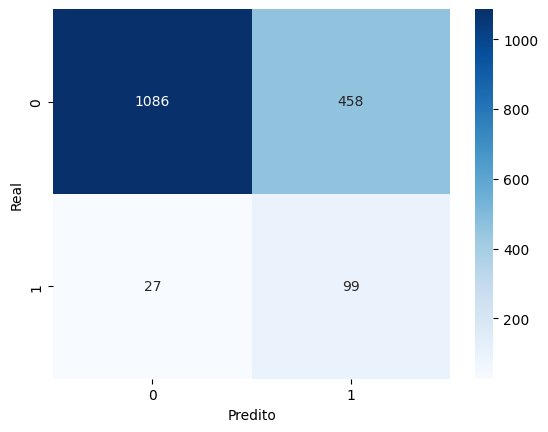

Sensitivity :  0.7033678756476683
Specificity :  0.7857142857142857
AUC = 0.8247234558763057 


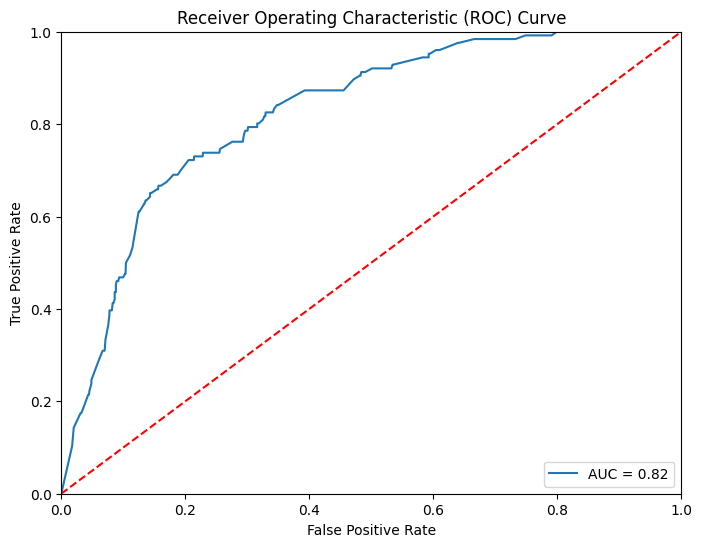

,Estado,AUC,sensitivity,specificity,Acurácia balanceada,Acurácia
0,Mato Grosso,0.824723,0.703368,0.785714,0.744541,0.709581


In [172]:
file_path = "drive/My Drive/databetes/data/processed/PNS_2019/pns_model_test.csv"
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df_test_cache = pd.read_csv(file_path)

# df_test = df_test_cache
df_test = df_test_cache.copy()
# df_full_metrics = pd.DataFrame()
for city in df_test['Unidade'].unique():
  if 'Mato Grosso' in city:

    df_test = df_test_cache.copy()
    print(city)
    df_test = df_test[df_test['Unidade'] == city]
    df_test = df_test[['IMC', 'diabetes','pressao_alta','exercicio_fisico','grau_escolaridade', 'bebida_alcoolica','Idade']]

    df_test = preprocess_subset(df_test)

    X_test =  df_test.drop('diabetes', axis=1)
    X_test =  df_test.drop(['cat_alcool_3','cat_alcool_6'], axis=1)

    y_test = df_test['diabetes']
    X_test=  X_test.drop('diabetes', axis=1)
    try:
      X_test =X_test[ordem_colunas]
    except KeyError:
      # "['grau_escolaridade_curso primário'] not in index"
      X_test['grau_escolaridade_curso primário'] = 0
      X_test =X_test[ordem_colunas]

    y_pred = loaded_model.predict(X_test)
    y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

    # print_classification_report(y_test, y_pred,y_pred_proba)
    df_met = print_classification_report_with_df(y_test, y_pred,y_pred_proba,state=city)
    display(df_met)

    # df_full_metrics = df_full_metrics.concat(df_met)
    # df_full_metrics = pd.concat([df_full_metrics,df_met])

# df_full_metrics

In [173]:
y_pred
# Contando os 0s e 1s
contagem = np.bincount(y_pred)

# Obtendo a contagem de 0s e 1s
zeros = contagem[0]
uns = contagem[1]

# Calculando a proporção
proporcao = (uns / (zeros + uns))*100

# Exibindo os resultados
print(f"Quantidade de Não Diabéticos: {zeros}")
print(f"Quantidade de Diabéticos: {uns}")
print(f"Proporção de Diabéticos: {proporcao:.2f}%")

Quantidade de Não Diabéticos: 1113
Quantidade de Diabéticos: 557
Proporção de Diabéticos: 33.35%


In [174]:
contagem = np.bincount(y_test)

# Obtendo a contagem de 0s e 1s
zeros = contagem[0]
uns = contagem[1]

# Calculando a proporção
proporcao = (uns / (zeros + uns))*100

# Exibindo os resultados
print(f"Quantidade de Não Diabéticos: {zeros}")
print(f"Quantidade de Diabéticos: {uns}")
print(f"Proporção de Diabéticos: {proporcao:.2f}%")

Quantidade de Não Diabéticos: 1544
Quantidade de Diabéticos: 126
Proporção de Diabéticos: 7.54%


Maranhão - 6% diabéticos

Maranhão


,IMC,diabetes,pressao_alta,exercicio_fisico,grau_escolaridade,faixa_etaria,cat_alcool_0,cat_alcool_1,cat_alcool_2
17,24.913495,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,25 a 34 anos,1,0,0
46,30.367347,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,25 a 34 anos,1,0,0
50,24.508946,0,não,sim,2º grau ou colégio ou técnico ou normal ou cie...,45 a 54 anos,0,0,1
70,33.203125,0,sim,não,2º grau ou colégio ou técnico ou normal ou cie...,25 a 34 anos,0,1,0
78,29.585799,0,não,sim,1º grau ou fundamental ou supletivo de 1º grau,45 a 54 anos,0,0,1
...,...,...,...,...,...,...,...,...,...
57258,28.133657,0,não,não,2º grau ou colégio ou técnico ou normal ou cie...,25 a 34 anos,1,0,0
57279,26.769780,0,não,sim,3º grau ou curso superior,35 a 44 anos,0,0,1
57284,25.711662,0,não,sim,2º grau ou colégio ou técnico ou normal ou cie...,35 a 44 anos,0,0,1
57291,28.282828,0,sim,não,1º grau ou fundamental ou supletivo de 1º grau,55 a 64 anos,1,0,0


cat_alcool_3
cat_alcool_4
cat_alcool_5
cat_alcool_6
cat_alcool_7


,IMC,diabetes,cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_3,cat_alcool_4,cat_alcool_5,cat_alcool_6,cat_alcool_7,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",faixa_etaria_18 a 24 anos,faixa_etaria_25 a 34 anos,faixa_etaria_35 a 44 anos,faixa_etaria_45 a 54 anos,faixa_etaria_55 a 64 anos,faixa_etaria_65 anos e mais
17,24.913495,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
46,30.367347,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
50,24.508946,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
70,33.203125,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
78,29.585799,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57258,28.133657,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
57279,26.769780,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
57284,25.711662,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
57291,28.282828,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Acurácia na validação: 76.03%
Acurácia balanceada na validação: 74.89%
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2338
           1       0.16      0.74      0.26       144

    accuracy                           0.76      2482
   macro avg       0.57      0.75      0.56      2482
weighted avg       0.93      0.76      0.82      2482



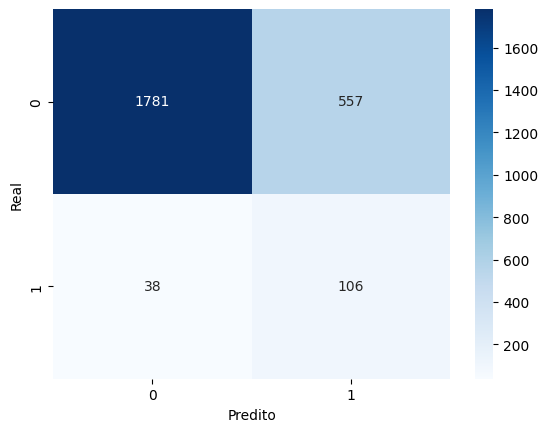

Sensitivity :  0.7617621899059025
Specificity :  0.7361111111111112
AUC = 0.8204572996863416 


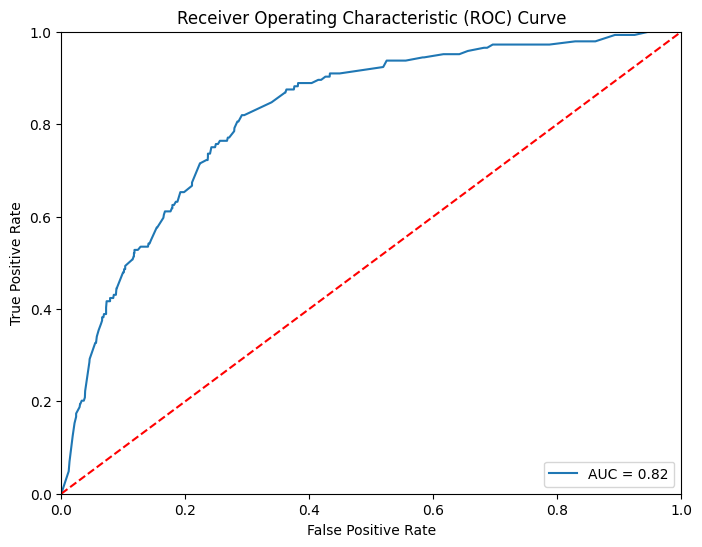

,Estado,AUC,sensitivity,specificity,Acurácia balanceada,Acurácia
0,Maranhão,0.820457,0.761762,0.736111,0.748937,0.760274


In [175]:
file_path = "drive/My Drive/databetes/data/processed/PNS_2019/pns_model_test.csv"
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df_test_cache = pd.read_csv(file_path)

# df_test = df_test_cache
df_test = df_test_cache.copy()
# df_full_metrics = pd.DataFrame()
for city in df_test['Unidade'].unique():
  if 'Maranhão' in city:

    df_test = df_test_cache.copy()
    print(city)
    df_test = df_test[df_test['Unidade'] == city]
    df_test = df_test[['IMC', 'diabetes','pressao_alta','exercicio_fisico','grau_escolaridade', 'bebida_alcoolica','Idade']]

    df_test = preprocess_subset(df_test)

    X_test =  df_test.drop('diabetes', axis=1)
    X_test =  df_test.drop(['cat_alcool_3','cat_alcool_6'], axis=1)

    y_test = df_test['diabetes']
    X_test=  X_test.drop('diabetes', axis=1)
    try:
      X_test =X_test[ordem_colunas]
    except KeyError:
      # "['grau_escolaridade_curso primário'] not in index"
      X_test['grau_escolaridade_curso primário'] = 0
      X_test =X_test[ordem_colunas]

    y_pred = loaded_model.predict(X_test)
    y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]

    # print_classification_report(y_test, y_pred,y_pred_proba)
    df_met = print_classification_report_with_df(y_test, y_pred,y_pred_proba,state=city)
    display(df_met)

In [176]:
y_pred
# Contando os 0s e 1s
contagem = np.bincount(y_pred)

# Obtendo a contagem de 0s e 1s
zeros = contagem[0]
uns = contagem[1]

# Calculando a proporção
proporcao = (uns / (zeros + uns))*100

# Exibindo os resultados
print(f"Quantidade de Não Diabéticos: {zeros}")
print(f"Quantidade de Diabéticos: {uns}")
print(f"Proporção de Diabéticos: {proporcao:.2f}%")

Quantidade de Não Diabéticos: 1819
Quantidade de Diabéticos: 663
Proporção de Diabéticos: 26.71%


In [177]:
contagem = np.bincount(y_test)

# Obtendo a contagem de 0s e 1s
zeros = contagem[0]
uns = contagem[1]

# Calculando a proporção
proporcao = (uns / (zeros + uns))*100

# Exibindo os resultados
print(f"Quantidade de Não Diabéticos: {zeros}")
print(f"Quantidade de Diabéticos: {uns}")
print(f"Proporção de Diabéticos: {proporcao:.2f}%")

Quantidade de Não Diabéticos: 2338
Quantidade de Diabéticos: 144
Proporção de Diabéticos: 5.80%


## Porque o modelo está falando isso? qual o motivo das predições de forma geral? lime para cada cidade

In [181]:
import lime
import lime.lime_tabular

In [182]:
df_lime = df_test.drop('diabetes', axis=1)
explainer = lime.lime_tabular.LimeTabularExplainer(X_test, feature_names=list(df_lime.columns),
                                                    class_names=['0', '1'], discretize_continuous=True)
explanation = explainer.explain_instance(X_test[0], loaded_model.predict_proba, num_features=len(df_lime.columns))

InvalidIndexError: ignored

In [179]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=8c0c167c5e0c2322c101965e53fe3e65e87eac7c494e445d71955afb9424081c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
# import optuna
# import optuna.visualization
import lime
import lime.lime_tabular

def train_model_with_lime(X_train, X_val, y_train, y_val, grid_search=False, trials=10, view_trees=False, model='baseline'):
    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)
    X_train = normalized_train_X

    # normalize X validation
    normalized_X_val = scaler.transform(X_val)
    X_val = normalized_X_val

    if grid_search:
        print("User chose to do gridsearch")
        def create_model(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'max_depth': trial.suggest_int('max_depth', 4, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            }
            model = RandomForestClassifier(random_state=SEED, **params)
            return model

        def objective(trial: optuna.trial.Trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'max_depth': trial.suggest_int('max_depth', 4, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            }
            model = create_model(trial)
            model.fit(normalized_train_X, y_train)
            y_pred = model.predict(X_val)
            score = balanced_accuracy_score(y_val, y_pred)
            return score

        study_rf = optuna.create_study(direction='maximize')
        study_rf.optimize(objective, n_trials=trials)

        fig = optuna.visualization.plot_optimization_history(study_rf)
        fig.show()

        # Create the best performing model
        print("Creating the best model predictions")
        model = create_model(study_rf.best_trial)
        display(model)
        display(model.get_params())

        model.fit(normalized_train_X, y_train)
        y_pred = model.predict(X_val)
    else:
        print("Running models with no gridsearch")
        if model == 'baseline':
            # Baseline
            model = RandomForestClassifier(random_state=SEED, n_estimators=500, max_depth=30, min_samples_leaf=5,
                                           n_jobs=-1)
        elif model == 'tuned':
            # Tuned without SMOTE
            model = RandomForestClassifier(max_depth=46, n_estimators=842, random_state=SEED)
        elif model == 'tunedsmote':
            # Tuned with SMOTE
            model = RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
                                           n_estimators=160, random_state=SEED)
        elif model == 'tunedadasys':
            params = {'bootstrap': True,
                      'ccp_alpha': 0.0,
                      'criterion': 'gini',
                      'max_depth': 8,
                      'max_features': 'sqrt',
                      'min_impurity_decrease': 0.0,
                      'min_samples_leaf': 1,
                      'min_samples_split': 146,
                      'min_weight_fraction_leaf': 0.0,
                      'n_estimators': 272,
                      'oob_score': False,
                      'verbose': 0,
                      'warm_start': False}
            model = RandomForestClassifier(random_state=SEED, **params)
        elif model == 'xgboost':
            xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
            model = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                             'n_estimators': [50, 100, 200]}, verbose=1,
                                 n_jobs=2)
        else:
            print("Specify model params")

        model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    try:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    except:
        y_pred_proba = y_pred

    # Lime explanation
    # df_lime = df_train.drop('diabetes', axis=1)
    # explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=list(df_lime.columns),
    #                                                    class_names=['0', '1'], discretize_continuous=True)
    # explanation = explainer.explain_instance(X_val[0], model.predict_proba, num_features=len(df_train.columns))

    return model, X_val, y_pred, y_val, y_pred_proba#, explainer

## antigo

## Referência métricas

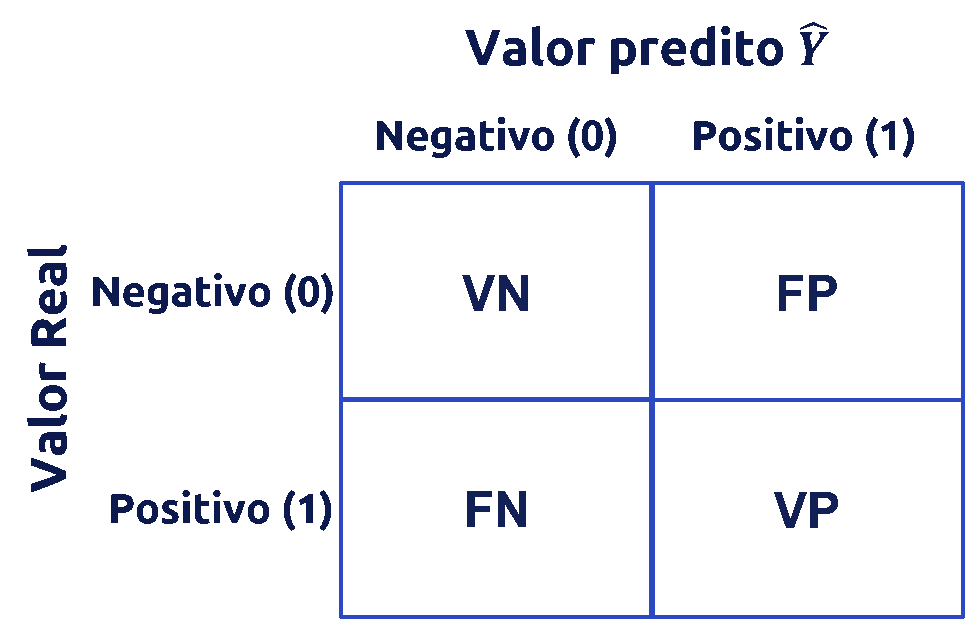![image.png]()

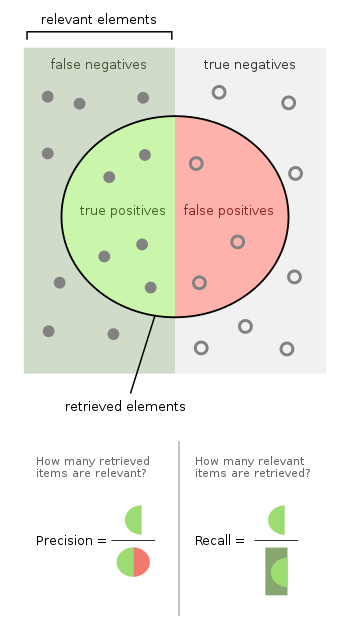

quais dados ele errou?

In [ ]:
# column_names = ['imc','pressao_alta_sim','cat_alcool_7','grau_escolaridade_curso primário','faixa_etaria_65+']

In [ ]:
# df_wrong = X_val[y_val != y_pred]

In [ ]:

# df_wrong = pd.DataFrame(df_wrong, columns=column_names)

In [ ]:
# df_wrong

In [ ]:
# # Função para criar boxplots em subplots com 2 linhas e 5 colunas
# def create_histograms_subplots(df):
#     # Determinar o número de colunas e linhas dos subplots
#     num_cols = 5
#     num_rows = 1

#     # Determinar o tamanho total da figura
#     figsize = (15, 6)

#     # Criar a figura e os subplots
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)

#     # Redimensionar o array de subplots
#     axs = axs.flatten()

#     # Iterar sobre cada coluna do dataframe
#     for i, column in enumerate(df.columns):
#         # Criar o histograma para a coluna atual
#         axs[i].hist(df[column])
#         axs[i].set_xlabel('Valor')
#         axs[i].set_ylabel('Frequência')
#         axs[i].set_title(f'Histograma para {column}')

#     # Ajustar o espaçamento entre os subplots
#     plt.tight_layout()

#     # Exibir a figura
#     plt.show()

# # Chamar a função para criar os boxplots separados
# create_histograms_subplots(df_wrong)

In [ ]:
# #preveu diabetes e não é - false positive
# df_fp = X_val[(y_val == 0) & (y_pred== 1)]

# df_fp = pd.DataFrame(df_fp, columns=column_names)
# display(df_fp)
# create_histograms_subplots(df_fp)

In [ ]:
# #preveu sem diabetes e não é - false negative
# df_fn = X_val[(y_val == 1) & (y_pred== 0)]

# df_fn = pd.DataFrame(df_fn, columns=column_names)
# display(df_fn)
# create_histograms_subplots(df_fn)

## teste de gpu

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

# referências antigas

In [ ]:
# import pdb
# pdb.set_trace()
# import sys
# !kill -9 -1
stopp

In [ ]:
# normalização

# Criando um objeto scaler
scaler = MinMaxScaler()

# Selecionando as colunas para normalização
cols_to_normalize = ['imc','peso']

# Aplicando a normalização min-max nas colunas selecionadas
df_ada[cols_to_normalize] = scaler.fit_transform(df_ada[cols_to_normalize])

In [ ]:
df_ada

In [ ]:
# Vamos primeiro separar as variáveis independentes (features) da variável dependente (target):
X = df_ada.drop('diabetes', axis=1)
y = df_ada['diabetes']

In [ ]:
def train_model(X, y, model_type='logistic_regression', grid_search=False):
    # Dividindo os dados em treino, validação e teste
    train_ratio = 0.75
    validation_ratio = 0.15
    test_ratio = 0.10

    # train é 75% do dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42)

    # test é 10% do dataset inicial
    # validation é 10% do dataset inicial
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

    print(X_train, X_val, X_test)
    if model_type == 'logistic_regression':
        # Criando o modelo de Regressão Logística
        model = LogisticRegression(random_state=42)
        params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}
    elif model_type == 'random_forest':
        # Criando o modelo de Random Forest
        model = RandomForestClassifier(random_state=42,max_depth=15)
        params = {'n_estimators': [100, 300, 500], 'max_depth': [5, 10,15, 20], 'min_samples_leaf': [1, 3, 5]}

    if grid_search:
        # Definindo os parâmetros para busca
        grid_search_cv = GridSearchCV(model, params, scoring='accuracy', cv=5, n_jobs=-1)

        # Treinando o modelo com a busca em grid
        grid_search_cv.fit(X_train, y_train)

        # Selecionando o melhor modelo encontrado na busca em grid
        model = grid_search_cv.best_estimator_

    # Treinando o modelo nos dados de treino
    model.fit(X_train, y_train)

    # Avaliando o modelo nos dados de validação
    y_pred = model.predict(X_val)

    return model, X_val, X_test, y_val,y_pred, y_test

In [ ]:
def print_classification_report(y_val, y_val_pred):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    # Gerando o relatório com diversas métricas
    report = classification_report(y_val, y_val_pred)

    # Exibindo o relatório
    print(report)

    # Plotando a matriz de confusão
    matriz_confusão = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()


In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y)

In [ ]:
print_classification_report(y_val, y_pred)

In [ ]:
print(f'\n os pesos do modelo são:{model.coef_[0]} e o bias é {model.intercept_[0]}')

Balanceamento de classes

In [ ]:

# Separando as classes majoritária e minoritária
df_majority = df_ada[df_ada['diabetes'] == 0]
df_minority = df_ada[df_ada['diabetes'] == 1]

# Fazendo o downsample da classe majoritária
df_majority_downsampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=42)

# Concatenando as classes majoritária e minoritária
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separando os dados de entrada (X) e a variável a ser prevista (y)
X = df_downsampled.drop('diabetes', axis=1)
y = df_downsampled['diabetes']

In [ ]:
# ax = sns.countplot(df_downsampled['diabetes'])
# for p in ax.patches:
#    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y)
print("Parâmetros do modelo :")
print(model.get_params())

In [ ]:
print_classification_report(y_val, y_pred)

In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y,model_type = 'random_forest',grid_search=False)
print_classification_report(y_val, y_pred)
print(model.get_params())


In [ ]:
print(f'\n os pesos do modelo são:{model.feature_importances_} ')

In [ ]:
# random forest, com gridsearch demora uns 5 minutos

tic = time.perf_counter()
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y,model_type = 'random_forest',grid_search=True)
toc = time.perf_counter()
print_classification_report(y_val, y_pred)
print(model.get_params())

In [ ]:
time_train = toc-tic
print(f"Modelo treinado em {time_train/60:0.4f} minutos")

In [ ]:
df_ada

In [ ]:
print(f'\n os pesos do modelo são:{model.feature_importances_} ')